## Test Large-Sample Mushroom Performance

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
from sklearn.datasets import fetch_openml
import pandas as pd
from bart_playground import *
from bart_playground.bart import DefaultBART, LogisticBART

In [2]:
# Parameters
N_TREES = 50
NDPOST = 500
NSKIP = 0
RANDOM_STATE = 42

# If debug then run with only one dataset and record running time
# Otherwise run with all datasets
debug = False
np.random.seed(RANDOM_STATE)

In [3]:
import math
from sklearn.preprocessing import OrdinalEncoder, normalize

def load_mushroom():
    X, y = fetch_openml('mushroom', version=1, return_X_y=True)
    for col in X.select_dtypes('category'):
        # -1 in codes indicates NaN by pandas convention
        X[col] = X[col].cat.codes
    X = normalize(X)
    y_array = y.to_numpy().reshape(-1, 1)
    y_arm = OrdinalEncoder(dtype=int).fit_transform(y_array).flatten()
    
    # make the dataset a little bit smaller
    indices = np.random.choice(X.shape[0], size=8000, replace=False)
    # indices = range(X.shape[0])
    X = X[indices, :]
    y_arm = y_arm[indices]
    
    return X, y_arm

def load_mushroom_encoded():
    X, y_arm = load_mushroom()
    
    n_arm = np.max(y_arm) + 1
    dim = X.shape[1] * n_arm # total number of encoded covariates (location-encoded for each arm) 
    act_dim = X.shape[1] # number of covariates
    covariates = np.zeros((X.shape[0], dim))
    rewards = np.zeros((X.shape[0], ))
    for cursor in range(X.shape[0]):
        a = np.random.randint(0, n_arm)
        covariates[cursor, a * act_dim:(a * act_dim + act_dim)] = X[cursor]
        if y_arm[cursor] == a:
            rewards[cursor] = 1 # reward is 1 if the true category matches the chosen arm

    return covariates, rewards

In [4]:
# Load datasets
def load_datasets():
    X_mushroom, y_mushroom = load_mushroom()
    X_mr_encoded, y_mr_encoded = load_mushroom_encoded()
    
    return {
        "Mushroom": (X_mushroom, y_mushroom),
        # "Mushroom Encoded": (X_mr_encoded, y_mr_encoded)
    }

## Dataset Loading

In [5]:
old_settings = np.seterr(invalid='raise')

datasets = load_datasets()

In [6]:
for name, (X, y) in datasets.items():
    # Print dataset shapes
    print(f"Dataset: {name}\nX shape: {X.shape}, y shape: {y.shape}")
    # Print 0-1 distribution of y
    print(f"y distribution: {pd.Series(y).value_counts(normalize=True).to_dict()}")

Dataset: Mushroom
X shape: (8000, 22), y shape: (8000,)
y distribution: {0: 0.5175, 1: 0.4825}


## Experiments

In [7]:
ini_bart = DefaultBART(n_trees=N_TREES, ndpost=10, nskip=1, random_state=RANDOM_STATE)
ini_bart.fit(X, y)
ini_bart.predict(X)

ini_bart = LogisticBART(n_trees=N_TREES, ndpost=10, nskip=1, random_state=RANDOM_STATE)
ini_bart.fit(X, y)
ini_bart.predict(X)

Iterations:   0%|          | 0/11 [00:00<?, ?it/s]

Iterations: 100%|██████████| 11/11 [00:00<00:00, 11.10it/s]


array([0, 1, 1, ..., 1, 0, 1])

In [8]:

def record_evaluation_results(X, y, BARTClass=DefaultBART):
    global bart, X_test, y_test
    
    # Initialize BART model
    bart = BARTClass(n_trees=N_TREES, ndpost=NDPOST, nskip=NSKIP, random_state=RANDOM_STATE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    # Fit the model
    bart.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = np.clip(bart.predict(X_test), 1e-15, 1 - 1e-15)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    logloss = log_loss(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Log Loss: {logloss:.4f}, Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

In [9]:
record_evaluation_results(X, y, LogisticBART)

Iterations:   0%|          | 0/500 [00:00<?, ?it/s]

Iterations: 100%|██████████| 500/500 [00:12<00:00, 39.45it/s]


Log Loss: 0.2590, Accuracy: 0.9925, ROC AUC: 0.9923


In [10]:
%prun -s cumtime -D temp_profile.prof -q record_evaluation_results(X, y, LogisticBART)

fname = "profile_mushroom_log"

!mv temp_profile.prof {fname}.prof
!gprof2dot -f pstats {fname}.prof -o {fname}.dot
!dot -Tpng {fname}.dot -o {fname}.png

Iterations:   0%|          | 0/500 [00:00<?, ?it/s]

Iterations: 100%|██████████| 500/500 [00:15<00:00, 31.60it/s]


Log Loss: 0.2590, Accuracy: 0.9925, ROC AUC: 0.9923
 
*** Profile stats marshalled to file 'temp_profile.prof'.


In [ ]:
%prun -s cumtime -D temp_profile.prof -q record_evaluation_results(X, y)

fname = "profile_mushroom"

!mv temp_profile.prof {fname}.prof
!gprof2dot -f pstats {fname}.prof -o {fname}.dot
!dot -Tpng {fname}.dot -o {fname}.png

Iterations:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 100%|██████████| 1500/1500 [00:19<00:00, 75.49it/s]


Log Loss: 0.0127, Accuracy: 1.0000, ROC AUC: 1.0000
 
*** Profile stats marshalled to file 'temp_profile.prof'.


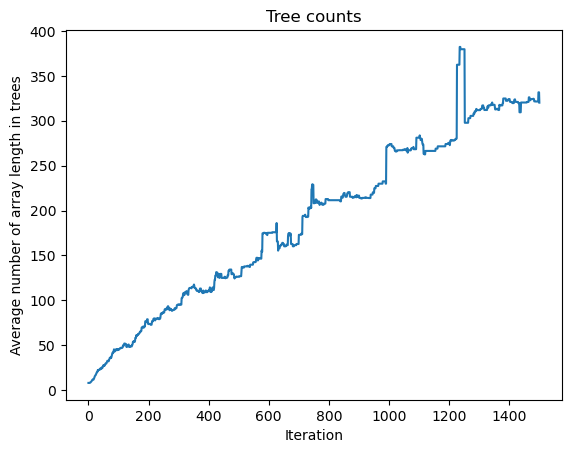

In [10]:
# plot
tree_counts = []
for i in range(len(bart.trace)):
    tree_counts.append(np.mean([len(arr) for arr in [tree.vars for tree in bart.trace[i].trees]]))
import matplotlib.pyplot as plt
plt.plot(tree_counts)
plt.title(f"Tree counts")
plt.xlabel("Iteration")
plt.ylabel("Average number of array length in trees")
plt.show()

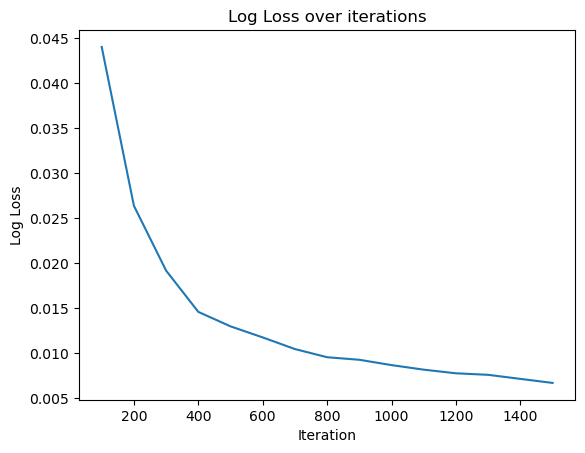

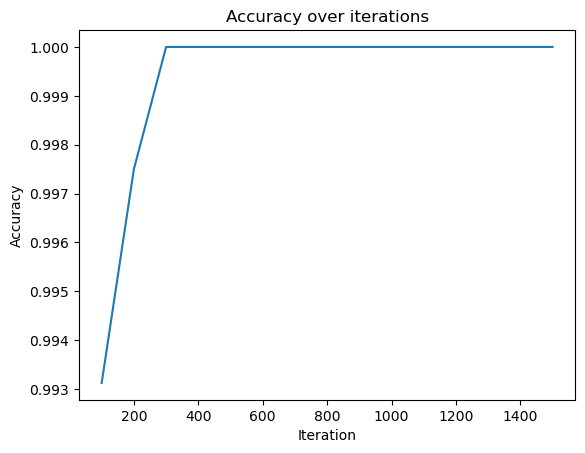

In [11]:
logloss_arr = []
acc_arr = []
its = []
for i in range(len(bart.trace)):
    if i>0 and i % 100 == 0:
        preds = np.zeros((X_test.shape[0], 50))
        for k in range(i-50, i):
            y_eval = bart.trace[k].evaluate(X_test)
            preds[:, k - (i-50)] = bart.preprocessor.backtransform_y(y_eval)
        mean_pred = np.mean(preds, axis=1)
    
        y_pred_prob = np.clip(mean_pred, 1e-15, 1 - 1e-15)
        logloss = log_loss(y_test, y_pred_prob)
        logloss_arr.append(logloss)
        y_pred = (y_pred_prob > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        acc_arr.append(accuracy)
        its.append(i)
        
plt.plot(its, logloss_arr)
plt.title(f"Log Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.show()
plt.plot(its, acc_arr)
plt.title(f"Accuracy over iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()